In [18]:
'''
METODOLOGÍA

A Continuación, se presenta la metodología de evaluación comparativa de
tres modelos de clasificación para predecir la columna "not.fully.paid",
de acuerdo al dataset adquirido. Esta evaluación se llevará a cabo apli-
cando redes neuronales artificiales (ANN), redes neuronales para K medias
(KNN), y redes neuronales convolucionales (CNN).Se empieza con el respec-t
ivo setup e importanción de las librerías con sus debidos parámetros para
las gráficas a emplear en la primera celda, siendo la segunda y la tercera
de la obtención de los dataframes, incluyendo la codificación de cada pro-
pósito de préstamo, inlcuyendo el "home_improvement", el cual no se encon
traba en el documento guía. Seguidamente, en la cuarta celda se procede a
realizar un análisis estadístico del dataset.
'''
#Importar librerias

import pandas as pd
import neurolab as nl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import random

#Ajustar tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7]
#Desactivar Warnings de Referenciado en pandas
pd.options.mode.chained_assignment = None

In [19]:
'''

'''

#Load CSV Data

with open(r"Data\Proy_Final_data.csv") as file:
    Data = pd.read_csv(file, sep= ",")

#Eliminar columna indice
Data = Data.drop({"Unnamed: 0"}, axis="columns")

print("-------------------------------")
print("Data Cargada: ")
print(Data.head(4))
print("-------------------------------")
print("Informacion del Dataset: ")
print(Data.info())
print("-------------------------------")

-------------------------------
Data Cargada: 
   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1         credit_card    0.1505       277.53       11.289782   
1              1  debt_consolidation    0.1253       133.87       10.596635   
2              1  debt_consolidation    0.1392       682.74       11.350407   
3              0           all_other    0.0768       405.48       10.736310   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  12.07   667        3509.041667       9229        93.2               1   
1  18.39   687        4050.000000       7227        70.9               0   
2  11.55   697        5220.000000      17250        78.3               2   
3  23.64   712        3240.000000      58996        55.7               3   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            1        0               0  
3       

In [20]:
#Codificacion de propositos
'''
    
'''
#Valores unicos de la columna de propositos
print("-------------------------------")
print("Valores unicos de la columna de propositos: ")
print(Data["purpose"].unique())
print("-------------------------------")

#Asignacion de valores numericos
Purposes = {
    "credit_card" : 0,
    "debt_consolidation" : 1,
    "educational" : 2,
    "major_purchase" : 3,
    "small_business" : 4,
    "all_other" : 5,
    "home_improvement" : 6
}

#Copia de dataset
CodedData = Data.copy()

#Asignacion de codigos a propositos
index = 0
for Purpose in Data["purpose"]:
    for UniquePurpose in Purposes:
        if UniquePurpose == Purpose:
            CodedData["purpose"][index] = Purposes[UniquePurpose] 
    index = index + 1

CodedData = CodedData.apply(pd.to_numeric)

#Dataset Codificado
print("-------------------------------")
print("Dataset Codificado: ")
print(CodedData.head())
print("-------------------------------")

-------------------------------
Valores unicos de la columna de propositos: 
['credit_card' 'debt_consolidation' 'all_other' 'major_purchase'
 'home_improvement' 'small_business' 'educational']
-------------------------------
-------------------------------
Dataset Codificado: 
   credit.policy  purpose  int.rate  installment  log.annual.inc    dti  fico  \
0              1        0    0.1505       277.53       11.289782  12.07   667   
1              1        1    0.1253       133.87       10.596635  18.39   687   
2              1        1    0.1392       682.74       11.350407  11.55   697   
3              0        5    0.0768       405.48       10.736310  23.64   712   
4              1        3    0.1537       174.24       10.463103  11.67   672   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs  \
0        3509.041667       9229        93.2               1            0   
1        4050.000000       7227        70.9               0            0   
2     

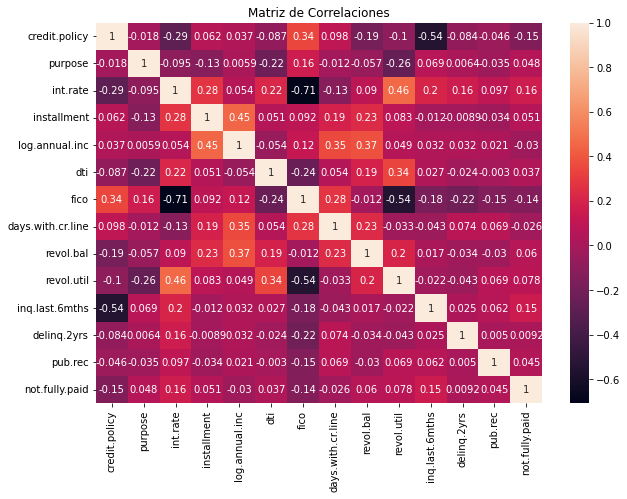

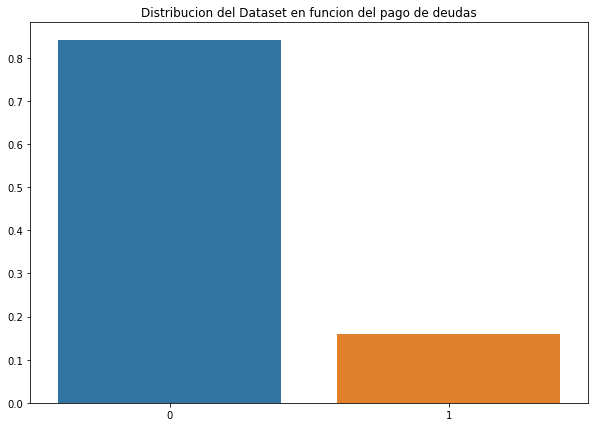

<Figure size 720x504 with 0 Axes>

In [21]:
'''
-ANÁLISIS ESTADÍSTICO DEL DATASET
En esta sección, se busca conocer a profundidad el comportamiento
del dataset a través de métodos estocásticos. Pero se debe tener
en cuenta que como se aplicarán redes neuronales para todos los 
modelos, es necesario normalizar las variables de manera que cada
una de ellas sean comparables entre síPara ello, se realiza un 
estudio de correlación, que brinda la librería "Seaborn", de cada 
variable codificada en la celda anterior, de la cual se observa que...

'''
#Estadisticos del Dataset

#Correlacion entre variables
Correlation = CodedData.corr()
sns.heatmap(Correlation, annot=True)
plt.title("Matriz de Correlaciones")
plt.figure(1)
plt.show()

#Grafico de distribucion del dataset
sns.barplot(x = (CodedData["not.fully.paid"].unique()), 
            y = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/CodedData.shape[0])
plt.title("Distribucion del Dataset en funcion del pago de deudas")
plt.figure(2)
plt.show()

In [22]:
#Almacenado Dataset De prueba y  entrenamiento 

#Division de creditos aprobados y rechazados
RejectedDT = CodedData.loc[CodedData["not.fully.paid"] == 0].copy()
AProvedDT = CodedData.loc[CodedData["not.fully.paid"] == 1].copy()

NRejected = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[0]

#Seleccion de dataset de prueba balanceado (10% del dataset original)
AprovedTestDT = AProvedDT.sample(frac = 0.10, random_state = random.randrange(100,1000))
NAprovedTest = AprovedTestDT.shape[0]
RejectedTestDT = RejectedDT.sample(frac = NAprovedTest/NRejected, random_state = random.randrange(100,1000))
NRejectedTest = RejectedTestDT.shape[0]

#Dataset de entrenamiento
AprovedTrainDT = AProvedDT.drop(AprovedTestDT.index)
AprovedTrainDT = AprovedTrainDT.reset_index(drop = True)
RejectedTrainDT = RejectedDT.drop(RejectedTestDT.index)
RejectedTrainDT = RejectedTrainDT.reset_index(drop = True)

TrainDT = pd.concat([AprovedTrainDT, RejectedTrainDT], axis = 0, copy = True, ignore_index = True)
TrainDT = TrainDT.reset_index(drop = True)

In [23]:
#Metodologia de Dataset Completo

#Normalizar el Dataset
NormalizedData = (TrainDT - TrainDT.min())/(TrainDT.max() -TrainDT.min())

Epoch: 5; Error: 580.0974609157707;
Epoch: 10; Error: 519.4481637572335;
Epoch: 15; Error: 482.0080363474748;
Epoch: 20; Error: 476.4939693929709;
Epoch: 25; Error: 470.24322960617803;
Epoch: 30; Error: 468.25022832250426;
Epoch: 35; Error: 465.6018833767394;
Epoch: 40; Error: 462.4901431626921;
Epoch: 45; Error: 459.8731857929697;
Epoch: 50; Error: 458.3465376439117;
The maximum number of train epochs is reached


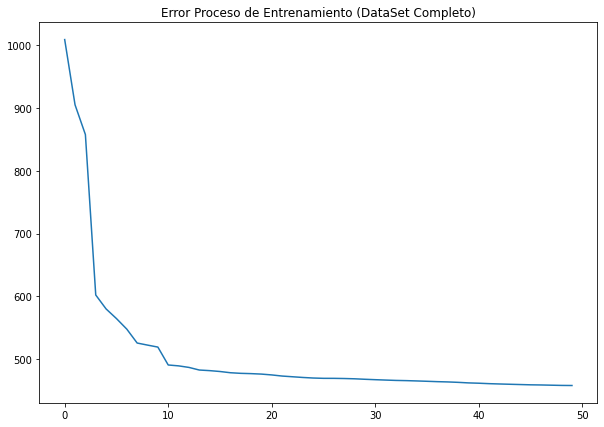

<Figure size 720x504 with 0 Axes>

In [24]:
#Red Neuronal
#Neuronas de entrada
NInput = [[0,1] for size in range(len(NormalizedData.columns) - 1)]

#Estructura Red Neuronal
Network = nl.net.newff(NInput,[10,1])

#Entradas de entrenamiento
TrainInputs = [[0 for size in range(len(NormalizedData.columns) - 1)] for size in range(NormalizedData.shape[0])]
for DtIndex in range(len(TrainInputs)):
    i = 0
    for Column in NormalizedData.columns:
        if (Column != "not.fully.paid"):
            (TrainInputs[DtIndex])[i] = NormalizedData[Column][DtIndex]
            i = i + 1

#Salidas de entrenamiento
TrainTarget = [[0] for size in range(NormalizedData.shape[0])]
for DtIndex in range(len(TrainTarget)):
    TrainTarget[DtIndex][0] = NormalizedData["not.fully.paid"][DtIndex]

NetworkError = Network.train(TrainInputs,TrainTarget, epochs = 50, goal = 0.5, show = 5)
Network.save(r"OutPut\ANN\FullDataset\Network_Dataset_Completo")

plt.plot(NetworkError)
plt.title("Error Proceso de Entrenamiento (DataSet Completo)")
plt.figure(3)
plt.show()

K = 1, Accuracy: 0.7649048625792811
Last Accuracy: 0.7649048625792811
K = 2, Accuracy: 0.8376321353065539
Last Accuracy: 0.8376321353065539
K = 3, Accuracy: 0.8143763213530656
Last Accuracy: 0.8143763213530656
K = 4, Accuracy: 0.8443974630021142
Last Accuracy: 0.8443974630021142
K = 5, Accuracy: 0.8317124735729386
Last Accuracy: 0.8317124735729386
K = 6, Accuracy: 0.8465116279069768
Last Accuracy: 0.8465116279069768
K = 7, Accuracy: 0.8431289640591966
Last Accuracy: 0.8431289640591966
K = 8, Accuracy: 0.8473572938689218
Last Accuracy: 0.8473572938689218
K = 9, Accuracy: 0.8448202959830867
Last Accuracy: 0.8448202959830867
K = 10, Accuracy: 0.8477801268498943
Last Accuracy: 0.8477801268498943
K = 11, Accuracy: 0.8465116279069768
Last Accuracy: 0.8465116279069768
K = 12, Accuracy: 0.8486257928118394
Last Accuracy: 0.8486257928118394
K = 13, Accuracy: 0.8482029598308668
Last Accuracy: 0.8482029598308668
K = 14, Accuracy: 0.8490486257928118
Last Accuracy: 0.8490486257928118
K = 15, Accurac

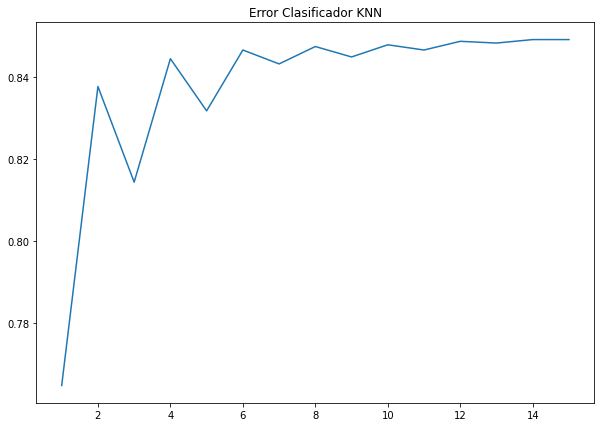

<Figure size 720x504 with 0 Axes>

In [25]:
#Clasificador KNN

XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), NormalizedData["not.fully.paid"],test_size = 0.3)

K = 1
LastAccuracy = 0

KNNmodel = KNeighborsClassifier(n_neighbors=K)
KNNmodel.fit(XTrain, YTrain)
YPredict = KNNmodel.predict(XTest)
Accuracy = metrics.accuracy_score(YTest, YPredict)
print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

AccuracyPlot = np.array(Accuracy)
KPlot = np.array(K)

while (Accuracy > LastAccuracy*0.95) and (round(Accuracy,5) != round(LastAccuracy,5)):
    K = K + 1
    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    LastAccuracy = Accuracy
    Accuracy = metrics.accuracy_score(YTest, YPredict)
    print("Last Accuracy: " + str(LastAccuracy))
    print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

    AccuracyPlot = np.append(AccuracyPlot, Accuracy)
    KPlot = np.append(KPlot, K)
pickle.dump(KNNmodel, open("OutPut\KNN\FullDataset\KNN_FullDataset", "wb"))
plt.plot(KPlot, AccuracyPlot)
plt.title("Error Clasificador KNN")
plt.figure(4)
plt.show()

Cantidades de creditos aprobados
1173
Candidades de creditos rechazados
6708
Numero de submuestras
5.718670076726343
Submuestras: 
(2346, 14)


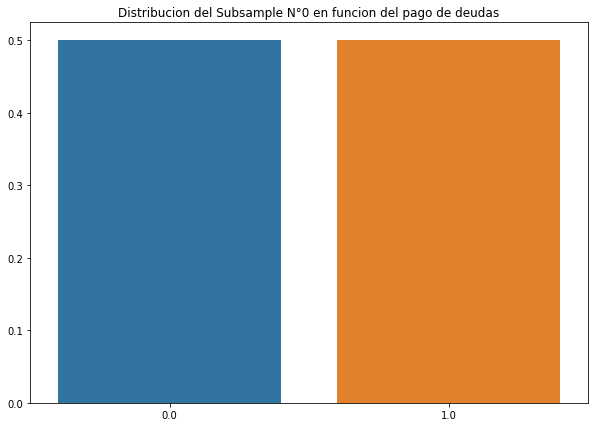

<Figure size 720x504 with 0 Axes>

(2346, 14)


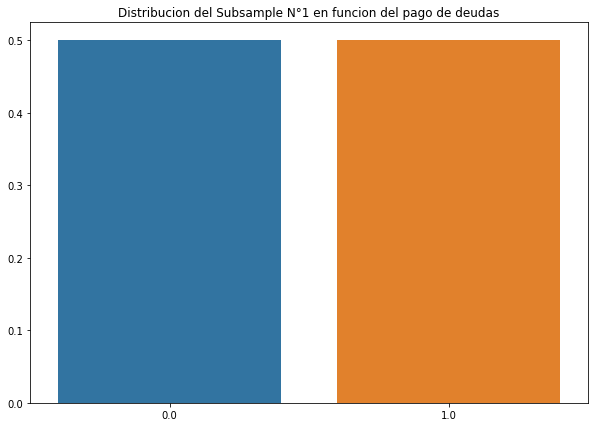

<Figure size 720x504 with 0 Axes>

(2346, 14)


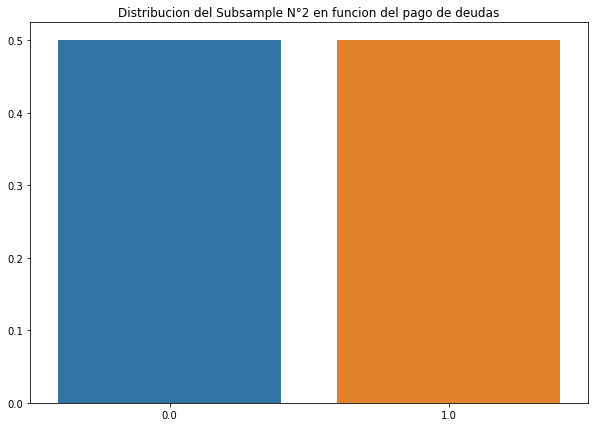

<Figure size 720x504 with 0 Axes>

(2346, 14)


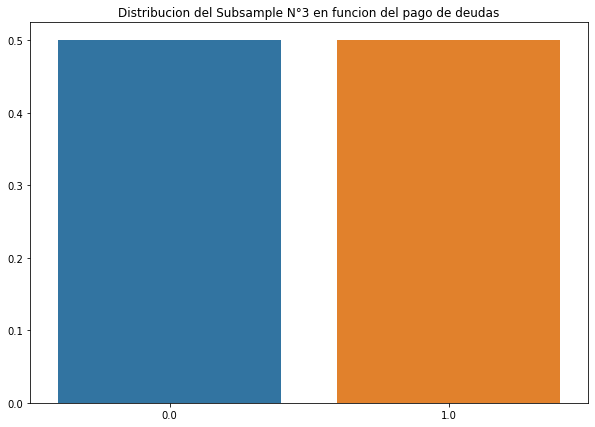

<Figure size 720x504 with 0 Axes>

(2346, 14)


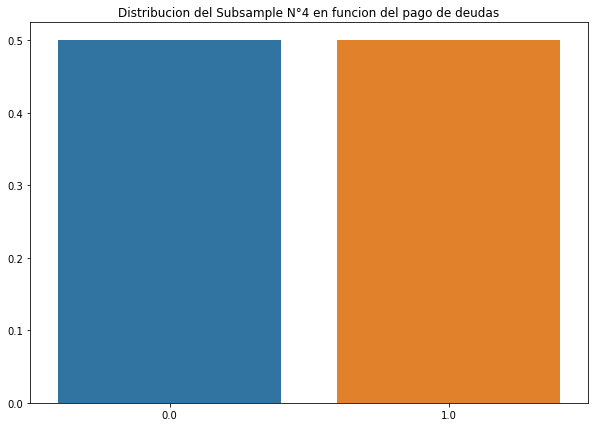

<Figure size 720x504 with 0 Axes>

In [26]:
#Metodologia de Balanceo por submuestreo de la clase mayoritaria

NAproved = TrainDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[1]
NRejected = TrainDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[0]
NSubsamples = (NRejected/NAproved)
print("Cantidades de creditos aprobados")
print(NAproved)
print("Candidades de creditos rechazados")
print(NRejected)
print("Numero de submuestras")
print(NSubsamples)

RejectedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 0].copy()
AProvedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 1].copy()

Subsamples = list()
for i in range(int(NSubsamples)):
    Subsample = RejectedDT.sample(frac = 1/(NSubsamples - i), random_state = random.randrange(100,1000))
    RejectedDT = RejectedDT.drop(Subsample.index)
    Subsample = pd.concat([Subsample, AProvedDT])
    Subsample = Subsample.reset_index(drop = True)
    Subsamples.append(Subsample)

print("Submuestras: ")
z = 0
for Subsample in Subsamples:
    print(Subsample.shape)
    sns.barplot(x = (Subsample["not.fully.paid"].unique()), 
            y = Subsample.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/Subsample.shape[0])
    plt.title("Distribucion del Subsample N°" + str(z) + " en funcion del pago de deudas")
    plt.figure(2)
    plt.show()
    z = z + 1

Epoch: 15; Error: 285.46002781770693;
Epoch: 30; Error: 263.78675726986654;
Epoch: 45; Error: 255.7994461914067;
The maximum number of train epochs is reached


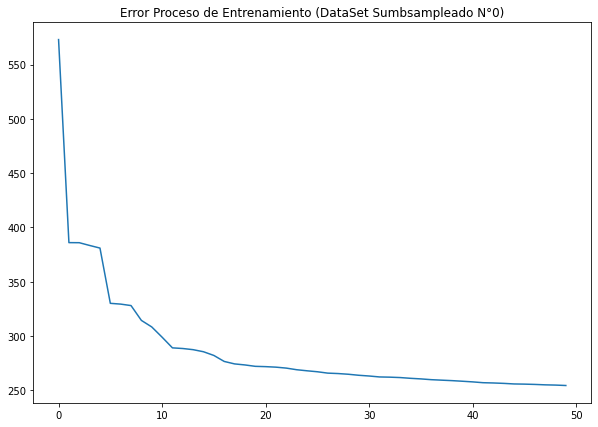

<Figure size 720x504 with 0 Axes>

Epoch: 15; Error: 250.1324130439769;
Epoch: 30; Error: 243.3895412291187;
Epoch: 45; Error: 238.74886561163504;
The maximum number of train epochs is reached


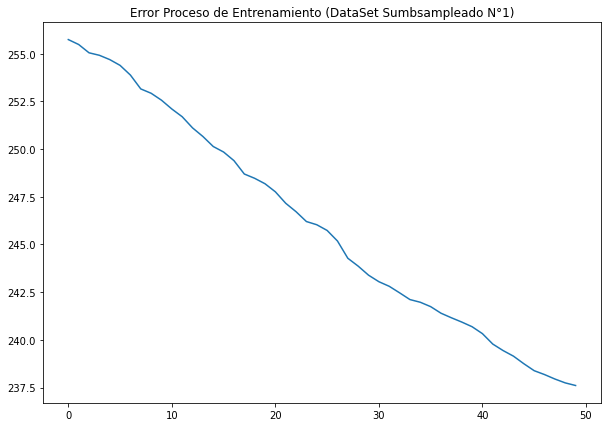

<Figure size 720x504 with 0 Axes>

Epoch: 15; Error: 251.9447388733073;
Epoch: 30; Error: 245.70058549333396;
Epoch: 45; Error: 241.41136535883498;
The maximum number of train epochs is reached


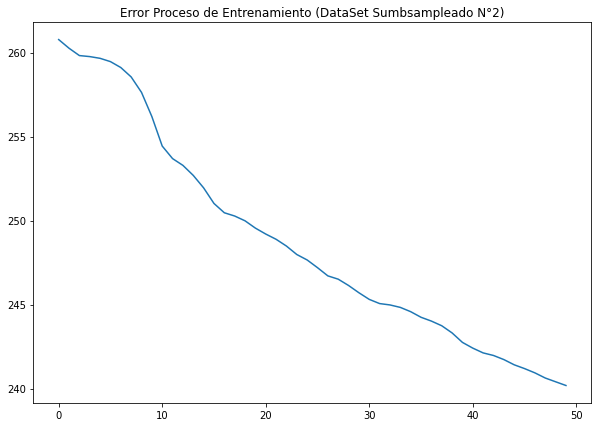

<Figure size 720x504 with 0 Axes>

Epoch: 15; Error: 250.71689636507824;
Epoch: 30; Error: 244.31918351768894;
Epoch: 45; Error: 240.5864053590468;
The maximum number of train epochs is reached


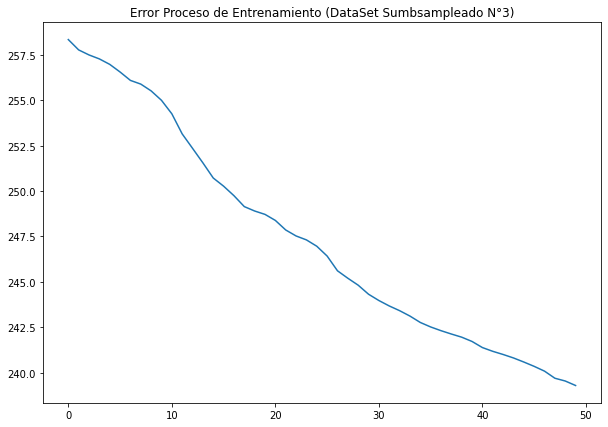

<Figure size 720x504 with 0 Axes>

Epoch: 15; Error: 256.18729217181954;
Epoch: 30; Error: 249.01250639057145;
Epoch: 45; Error: 246.10800894181773;
The maximum number of train epochs is reached


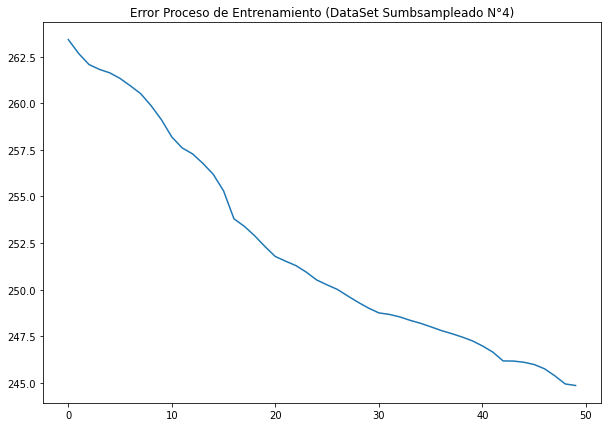

<Figure size 720x504 with 0 Axes>

In [27]:
z = 0
for Subsample in Subsamples:
    #Red Neuronal
    
    #Entradas de entrenamiento
    TrainInputs = [[0 for size in range(len(Subsample.columns) - 1)] for size in range(Subsample.shape[0])]
    for DtIndex in range(len(TrainInputs)):
        i = 0
        for Column in Subsample.columns:
            if (Column != "not.fully.paid"):
                (TrainInputs[DtIndex])[i] = Subsample[Column][DtIndex]
                i = i + 1

    #Salidas de entrenamiento
    TrainTarget = [[0] for size in range(Subsample.shape[0])]
    for DtIndex in range(len(TrainTarget)):
        TrainTarget[DtIndex][0] = Subsample["not.fully.paid"][DtIndex]

    if z == 0:
        #Neuronas de entrada
        NInput = [[0,1] for size in range(len(Subsample.columns) - 1)]
        #Estructura Red Neuronal
        Network = nl.net.newff(NInput,[10,1])
        NetworkError = Network.train(TrainInputs,TrainTarget, epochs = 50, goal = 0.5, show = 15)
        Network.save(r"OutPut\ANN\Subsample\Network_Subsample_equal")
    else:
        Network = nl.load(r"OutPut\ANN\Subsample\Network_Subsample_equal")
        NetworkError = Network.train(TrainInputs,TrainTarget, epochs = 50, goal = 0.5, show = 15)
        Network.save(r"OutPut\ANN\Subsample\Network_Subsample_equal")

    plt.plot(NetworkError)
    plt.title("Error Proceso de Entrenamiento (DataSet Sumbsampleado N°"+str(z)+")")
    plt.figure(4 + z)
    plt.show()

    z = z + 1


K = 1, Accuracy: 0.5440340909090909
Last Accuracy: 0.5440340909090909
K = 2, Accuracy: 0.5298295454545454
Last Accuracy: 0.5298295454545454
K = 3, Accuracy: 0.5383522727272727
Last Accuracy: 0.5383522727272727
K = 4, Accuracy: 0.5369318181818182
Last Accuracy: 0.5369318181818182
K = 5, Accuracy: 0.5454545454545454
Last Accuracy: 0.5454545454545454
K = 6, Accuracy: 0.546875
Last Accuracy: 0.546875
K = 7, Accuracy: 0.5596590909090909
Last Accuracy: 0.5596590909090909
K = 8, Accuracy: 0.5582386363636364
Last Accuracy: 0.5582386363636364
K = 9, Accuracy: 0.5696022727272727
Last Accuracy: 0.5696022727272727
K = 10, Accuracy: 0.5795454545454546
Last Accuracy: 0.5795454545454546
K = 11, Accuracy: 0.5525568181818182
Last Accuracy: 0.5525568181818182
K = 12, Accuracy: 0.5568181818181818
Last Accuracy: 0.5568181818181818
K = 13, Accuracy: 0.5667613636363636
Last Accuracy: 0.5667613636363636
K = 14, Accuracy: 0.5767045454545454
Last Accuracy: 0.5767045454545454
K = 15, Accuracy: 0.573863636363636

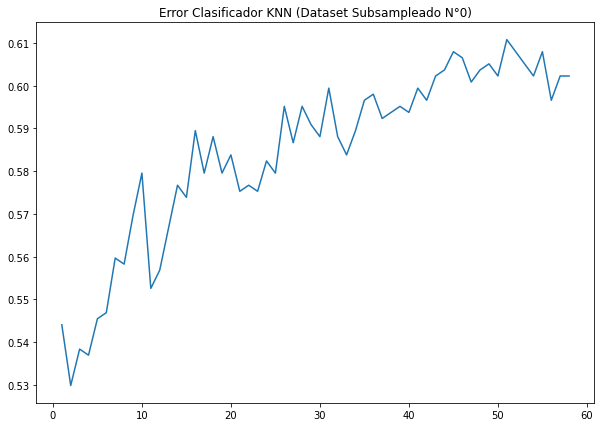

<Figure size 720x504 with 0 Axes>

K = 58, Accuracy: 0.6264204545454546
Last Accuracy: 0.6264204545454546
K = 59, Accuracy: 0.6136363636363636
Last Accuracy: 0.6136363636363636
K = 60, Accuracy: 0.6221590909090909
Last Accuracy: 0.6221590909090909
K = 61, Accuracy: 0.6122159090909091
Last Accuracy: 0.6122159090909091
K = 62, Accuracy: 0.6207386363636364
Last Accuracy: 0.6207386363636364
K = 63, Accuracy: 0.6136363636363636
Last Accuracy: 0.6136363636363636
K = 64, Accuracy: 0.609375
Last Accuracy: 0.609375
K = 65, Accuracy: 0.6079545454545454
Last Accuracy: 0.6079545454545454
K = 66, Accuracy: 0.6136363636363636
Last Accuracy: 0.6136363636363636
K = 67, Accuracy: 0.6207386363636364
Last Accuracy: 0.6207386363636364
K = 68, Accuracy: 0.609375
Last Accuracy: 0.609375
K = 69, Accuracy: 0.6122159090909091
Last Accuracy: 0.6122159090909091
K = 70, Accuracy: 0.6178977272727273
Last Accuracy: 0.6178977272727273
K = 71, Accuracy: 0.6065340909090909
Last Accuracy: 0.6065340909090909
K = 72, Accuracy: 0.6164772727272727
Last Accu

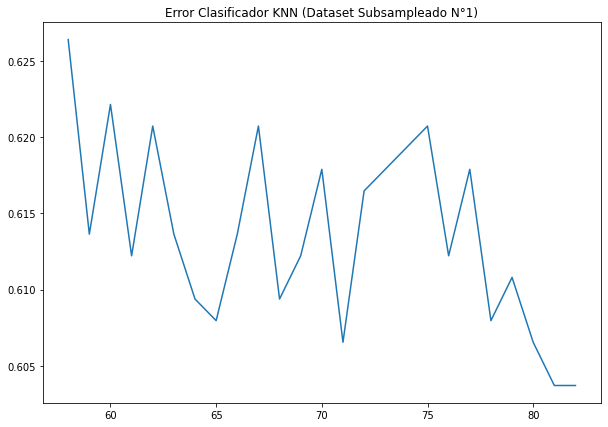

<Figure size 720x504 with 0 Axes>

K = 82, Accuracy: 0.5738636363636364
Last Accuracy: 0.5738636363636364
K = 83, Accuracy: 0.5767045454545454
Last Accuracy: 0.5767045454545454
K = 84, Accuracy: 0.5724431818181818
Last Accuracy: 0.5724431818181818
K = 85, Accuracy: 0.5738636363636364
Last Accuracy: 0.5738636363636364
K = 86, Accuracy: 0.5752840909090909
Last Accuracy: 0.5752840909090909
K = 87, Accuracy: 0.5767045454545454
Last Accuracy: 0.5767045454545454
K = 88, Accuracy: 0.5724431818181818
Last Accuracy: 0.5724431818181818
K = 89, Accuracy: 0.5795454545454546
Last Accuracy: 0.5795454545454546
K = 90, Accuracy: 0.5767045454545454
Last Accuracy: 0.5767045454545454
K = 91, Accuracy: 0.5823863636363636
Last Accuracy: 0.5823863636363636
K = 92, Accuracy: 0.5681818181818182
Last Accuracy: 0.5681818181818182
K = 93, Accuracy: 0.5795454545454546
Last Accuracy: 0.5795454545454546
K = 94, Accuracy: 0.5738636363636364
Last Accuracy: 0.5738636363636364
K = 95, Accuracy: 0.5795454545454546
Last Accuracy: 0.5795454545454546
K = 96

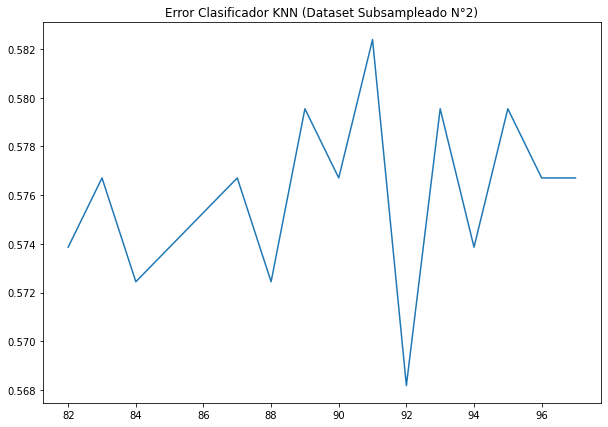

<Figure size 720x504 with 0 Axes>

K = 97, Accuracy: 0.6008522727272727
Last Accuracy: 0.6008522727272727
K = 98, Accuracy: 0.5980113636363636
Last Accuracy: 0.5980113636363636
K = 99, Accuracy: 0.5965909090909091
Last Accuracy: 0.5965909090909091
K = 100, Accuracy: 0.59375
Last Accuracy: 0.59375
K = 101, Accuracy: 0.5951704545454546
Last Accuracy: 0.5951704545454546
K = 102, Accuracy: 0.6008522727272727
Last Accuracy: 0.6008522727272727
K = 103, Accuracy: 0.5965909090909091
Last Accuracy: 0.5965909090909091
K = 104, Accuracy: 0.6008522727272727
Last Accuracy: 0.6008522727272727
K = 105, Accuracy: 0.6036931818181818
Last Accuracy: 0.6036931818181818
K = 106, Accuracy: 0.6036931818181818


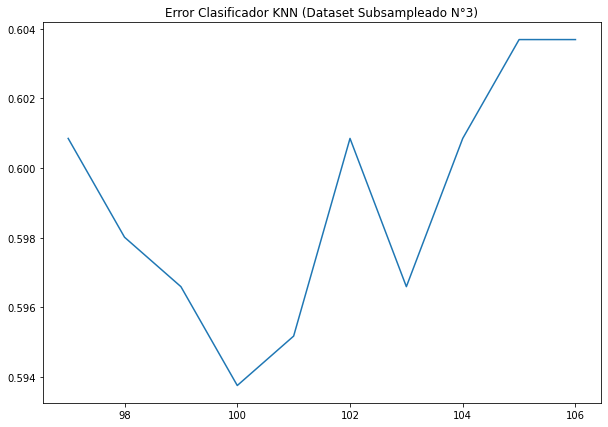

<Figure size 720x504 with 0 Axes>

K = 106, Accuracy: 0.6065340909090909
Last Accuracy: 0.6065340909090909
K = 107, Accuracy: 0.6107954545454546
Last Accuracy: 0.6107954545454546
K = 108, Accuracy: 0.6079545454545454
Last Accuracy: 0.6079545454545454
K = 109, Accuracy: 0.6065340909090909
Last Accuracy: 0.6065340909090909
K = 110, Accuracy: 0.6136363636363636
Last Accuracy: 0.6136363636363636
K = 111, Accuracy: 0.6136363636363636


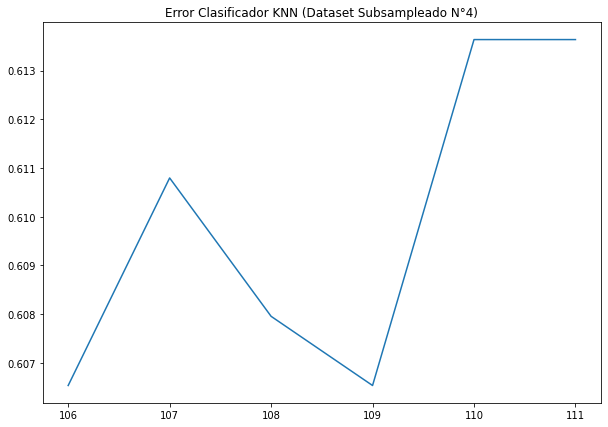

<Figure size 720x504 with 0 Axes>

In [28]:
z = 0
for subsample in Subsamples:
    #Clasificador KNN

    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), Subsample["not.fully.paid"],test_size = 0.3)

    
    if z == 0:
        K = 1
        LastAccuracy = 0
        KNNmodel = KNeighborsClassifier(n_neighbors=K)
    
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    Accuracy = metrics.accuracy_score(YTest, YPredict)
    print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

    AccuracyPlot = np.array(Accuracy)
    KPlot = np.array(K)

    while (Accuracy > LastAccuracy*0.95) and (round(Accuracy,5) != round(LastAccuracy,5)):
        K = K + 1
        KNNmodel = KNeighborsClassifier(n_neighbors=K)
        KNNmodel.fit(XTrain, YTrain)
        YPredict = KNNmodel.predict(XTest)
        LastAccuracy = Accuracy
        Accuracy = metrics.accuracy_score(YTest, YPredict)
        print("Last Accuracy: " + str(LastAccuracy))
        print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

        AccuracyPlot = np.append(AccuracyPlot, Accuracy)
        KPlot = np.append(KPlot, K)
    plt.plot(KPlot, AccuracyPlot)
    plt.title("Error Clasificador KNN (Dataset Subsampleado N°"+str(z)+")")
    plt.figure(4)
    plt.show()
    
    z = z + 1
pickle.dump(KNNmodel, open(r"OutPut\KNN\Subsample\KNN_Subsample", "wb"))

Epoch: 10; Error: 274.70566964269284;
Epoch: 20; Error: 267.11640257062265;
Epoch: 30; Error: 260.5610752930948;
Epoch: 40; Error: 255.92201703230558;
Epoch: 50; Error: 249.99827542834288;
The maximum number of train epochs is reached


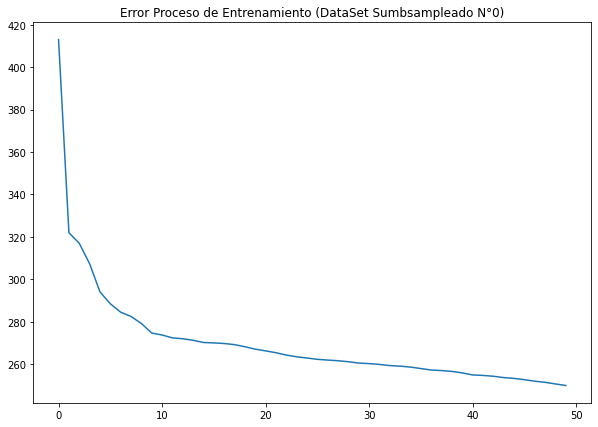

<Figure size 720x504 with 0 Axes>

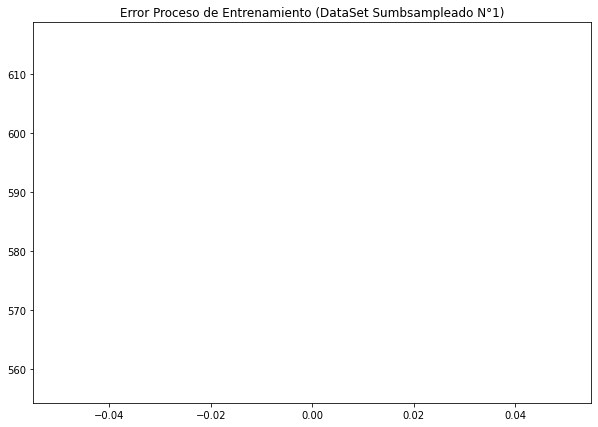

<Figure size 720x504 with 0 Axes>

Epoch: 10; Error: 267.07976004248974;
Epoch: 20; Error: 258.58445274119947;
Epoch: 30; Error: 253.13212262345473;
Epoch: 40; Error: 249.17460860134247;
Epoch: 50; Error: 245.6223470333821;
The maximum number of train epochs is reached


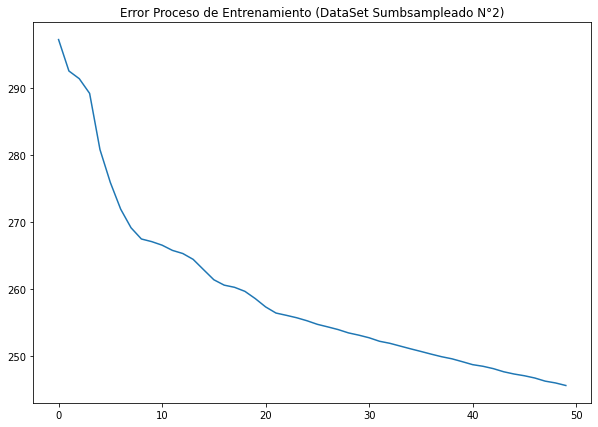

<Figure size 720x504 with 0 Axes>

Epoch: 10; Error: 289.95004869204945;
Epoch: 20; Error: 260.4713085224828;
Epoch: 30; Error: 256.64081905109754;
Epoch: 40; Error: 255.96256769891164;
Epoch: 50; Error: 254.88099128652388;
The maximum number of train epochs is reached


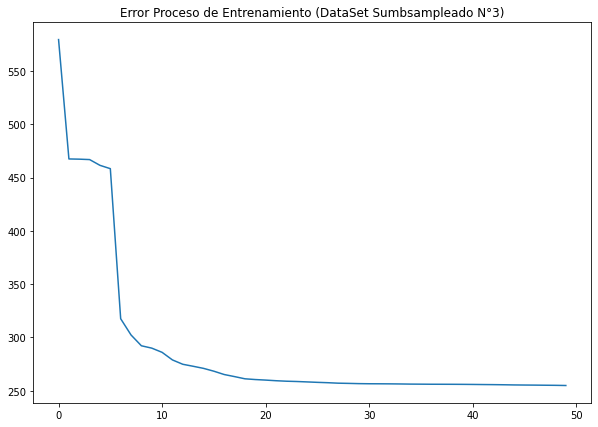

<Figure size 720x504 with 0 Axes>

Epoch: 10; Error: 283.3184077861197;
Epoch: 20; Error: 264.9555401401882;
Epoch: 30; Error: 259.0637494121559;
Epoch: 40; Error: 254.79252586695415;
Epoch: 50; Error: 250.9147810920903;
The maximum number of train epochs is reached


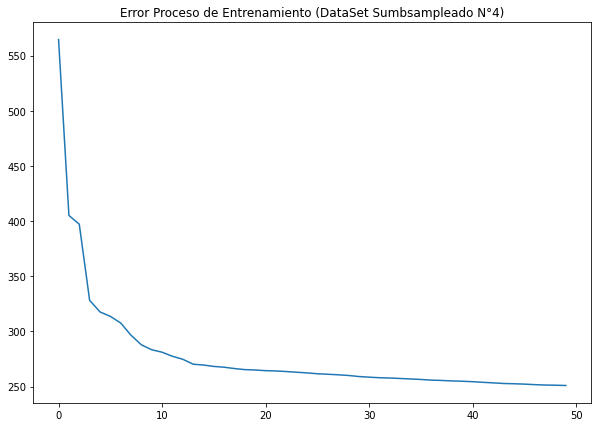

<Figure size 720x504 with 0 Axes>

In [29]:
#Ensemble con submuestreo

z = 0
for Subsample in Subsamples:
    #Red Neuronal
    
    #Entradas de entrenamiento
    TrainInputs = [[0 for size in range(len(Subsample.columns) - 1)] for size in range(Subsample.shape[0])]
    for DtIndex in range(len(TrainInputs)):
        i = 0
        for Column in Subsample.columns:
            if (Column != "not.fully.paid"):
                (TrainInputs[DtIndex])[i] = Subsample[Column][DtIndex]
                i = i + 1

    #Salidas de entrenamiento
    TrainTarget = [[0] for size in range(Subsample.shape[0])]
    for DtIndex in range(len(TrainTarget)):
        TrainTarget[DtIndex][0] = Subsample["not.fully.paid"][DtIndex]

    #Neuronas de entrada
    NInput = [[0,1] for size in range(len(Subsample.columns) - 1)]
    #Estructura Red Neuronal
    Network = nl.net.newff(NInput,[10,1])
    NetworkError = Network.train(TrainInputs,TrainTarget, epochs = 50, goal = 0.5, show = 10)
    Network.save(r"OutPut\ANN\Ensemble\Network_Ensemble_N" + str(z))

    plt.plot(NetworkError)
    plt.title("Error Proceso de Entrenamiento (DataSet Sumbsampleado N°"+str(z)+")")
    plt.figure(4 + z)
    plt.show()
    z = z + 1

K = 1, Accuracy: 0.5440340909090909
Last Accuracy: 0.5440340909090909
K = 2, Accuracy: 0.5340909090909091
Last Accuracy: 0.5340909090909091
K = 3, Accuracy: 0.5482954545454546
Last Accuracy: 0.5482954545454546
K = 4, Accuracy: 0.5355113636363636
Last Accuracy: 0.5355113636363636
K = 5, Accuracy: 0.53125
Last Accuracy: 0.53125
K = 6, Accuracy: 0.5596590909090909
Last Accuracy: 0.5596590909090909
K = 7, Accuracy: 0.5568181818181818
Last Accuracy: 0.5568181818181818
K = 8, Accuracy: 0.5454545454545454
Last Accuracy: 0.5454545454545454
K = 9, Accuracy: 0.5681818181818182
Last Accuracy: 0.5681818181818182
K = 10, Accuracy: 0.5426136363636364
Last Accuracy: 0.5426136363636364
K = 11, Accuracy: 0.5596590909090909
Last Accuracy: 0.5596590909090909
K = 12, Accuracy: 0.5582386363636364
Last Accuracy: 0.5582386363636364
K = 13, Accuracy: 0.5482954545454546
Last Accuracy: 0.5482954545454546
K = 14, Accuracy: 0.5625
Last Accuracy: 0.5625
K = 15, Accuracy: 0.5653409090909091
Last Accuracy: 0.5653409

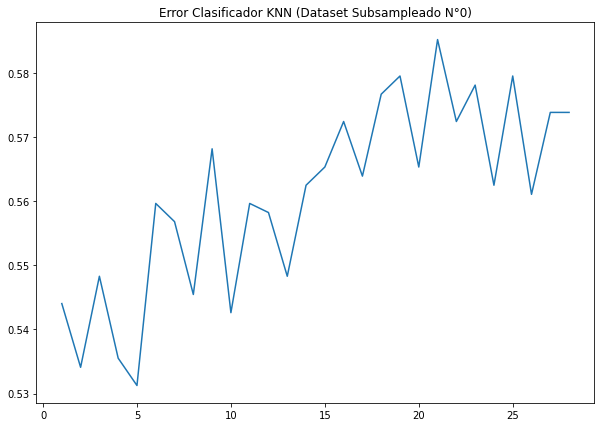

<Figure size 720x504 with 0 Axes>

K = 1, Accuracy: 0.5568181818181818
Last Accuracy: 0.5568181818181818
K = 2, Accuracy: 0.5553977272727273
Last Accuracy: 0.5553977272727273
K = 3, Accuracy: 0.5355113636363636
Last Accuracy: 0.5355113636363636
K = 4, Accuracy: 0.53125
Last Accuracy: 0.53125
K = 5, Accuracy: 0.5553977272727273
Last Accuracy: 0.5553977272727273
K = 6, Accuracy: 0.5610795454545454
Last Accuracy: 0.5610795454545454
K = 7, Accuracy: 0.59375
Last Accuracy: 0.59375
K = 8, Accuracy: 0.5568181818181818


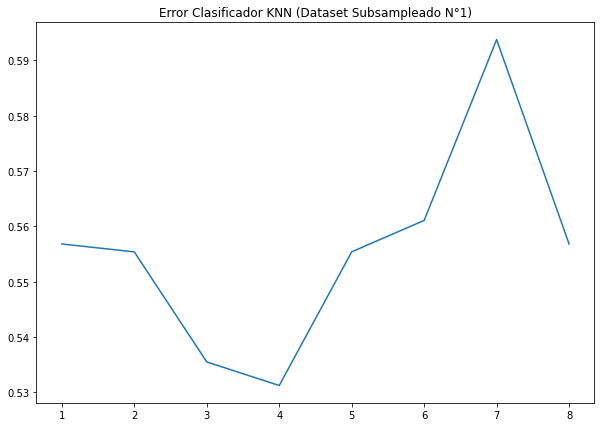

<Figure size 720x504 with 0 Axes>

K = 1, Accuracy: 0.5269886363636364
Last Accuracy: 0.5269886363636364
K = 2, Accuracy: 0.5284090909090909
Last Accuracy: 0.5284090909090909
K = 3, Accuracy: 0.5326704545454546
Last Accuracy: 0.5326704545454546
K = 4, Accuracy: 0.5411931818181818
Last Accuracy: 0.5411931818181818
K = 5, Accuracy: 0.5525568181818182
Last Accuracy: 0.5525568181818182
K = 6, Accuracy: 0.5596590909090909
Last Accuracy: 0.5596590909090909
K = 7, Accuracy: 0.5610795454545454
Last Accuracy: 0.5610795454545454
K = 8, Accuracy: 0.5497159090909091
Last Accuracy: 0.5497159090909091
K = 9, Accuracy: 0.5568181818181818
Last Accuracy: 0.5568181818181818
K = 10, Accuracy: 0.5639204545454546
Last Accuracy: 0.5639204545454546
K = 11, Accuracy: 0.5639204545454546


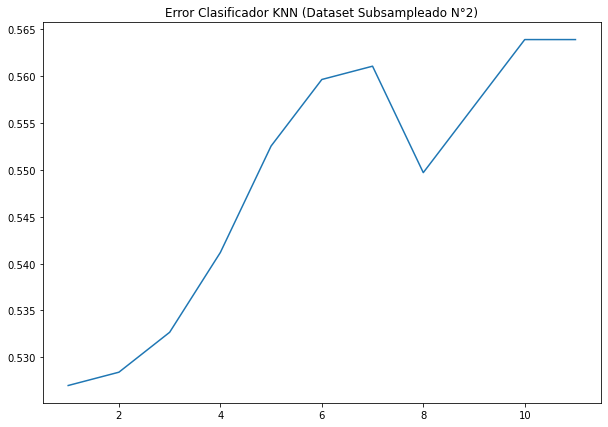

<Figure size 720x504 with 0 Axes>

K = 1, Accuracy: 0.5085227272727273
Last Accuracy: 0.5085227272727273
K = 2, Accuracy: 0.5014204545454546
Last Accuracy: 0.5014204545454546
K = 3, Accuracy: 0.5028409090909091
Last Accuracy: 0.5028409090909091
K = 4, Accuracy: 0.5340909090909091
Last Accuracy: 0.5340909090909091
K = 5, Accuracy: 0.5142045454545454
Last Accuracy: 0.5142045454545454
K = 6, Accuracy: 0.5284090909090909
Last Accuracy: 0.5284090909090909
K = 7, Accuracy: 0.5241477272727273
Last Accuracy: 0.5241477272727273
K = 8, Accuracy: 0.5198863636363636
Last Accuracy: 0.5198863636363636
K = 9, Accuracy: 0.5369318181818182
Last Accuracy: 0.5369318181818182
K = 10, Accuracy: 0.5227272727272727
Last Accuracy: 0.5227272727272727
K = 11, Accuracy: 0.5355113636363636
Last Accuracy: 0.5355113636363636
K = 12, Accuracy: 0.5340909090909091
Last Accuracy: 0.5340909090909091
K = 13, Accuracy: 0.5426136363636364
Last Accuracy: 0.5426136363636364
K = 14, Accuracy: 0.5426136363636364


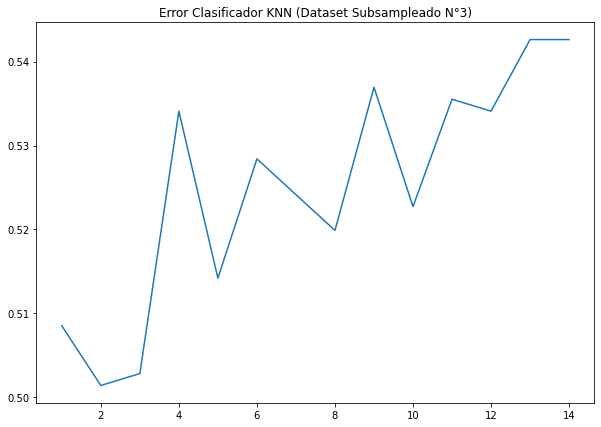

<Figure size 720x504 with 0 Axes>

K = 1, Accuracy: 0.5127840909090909
Last Accuracy: 0.5127840909090909
K = 2, Accuracy: 0.5213068181818182
Last Accuracy: 0.5213068181818182
K = 3, Accuracy: 0.5227272727272727
Last Accuracy: 0.5227272727272727
K = 4, Accuracy: 0.5213068181818182
Last Accuracy: 0.5213068181818182
K = 5, Accuracy: 0.5227272727272727
Last Accuracy: 0.5227272727272727
K = 6, Accuracy: 0.5284090909090909
Last Accuracy: 0.5284090909090909
K = 7, Accuracy: 0.5454545454545454
Last Accuracy: 0.5454545454545454
K = 8, Accuracy: 0.5397727272727273
Last Accuracy: 0.5397727272727273
K = 9, Accuracy: 0.5511363636363636
Last Accuracy: 0.5511363636363636
K = 10, Accuracy: 0.5369318181818182
Last Accuracy: 0.5369318181818182
K = 11, Accuracy: 0.5411931818181818
Last Accuracy: 0.5411931818181818
K = 12, Accuracy: 0.5511363636363636
Last Accuracy: 0.5511363636363636
K = 13, Accuracy: 0.5497159090909091
Last Accuracy: 0.5497159090909091
K = 14, Accuracy: 0.5397727272727273
Last Accuracy: 0.5397727272727273
K = 15, Accurac

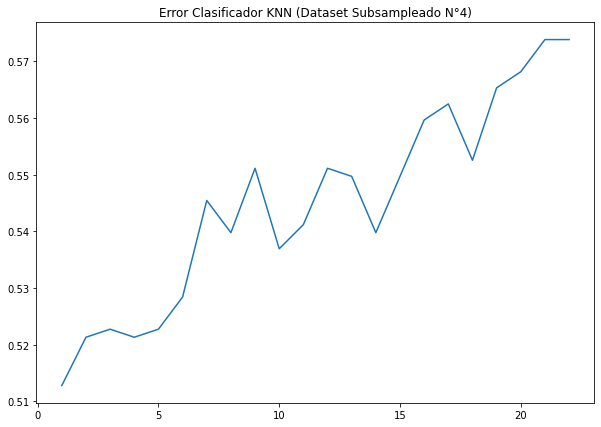

<Figure size 720x504 with 0 Axes>

In [30]:
z = 0
for subsample in Subsamples:
    #Clasificador KNN

    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), Subsample["not.fully.paid"],test_size = 0.3)

    K = 1
    LastAccuracy = 0

    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    Accuracy = metrics.accuracy_score(YTest, YPredict)
    print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

    AccuracyPlot = np.array(Accuracy)
    KPlot = np.array(K)

    while (Accuracy > LastAccuracy*0.95) and (round(Accuracy,5) != round(LastAccuracy,5)):
        K = K + 1
        KNNmodel = KNeighborsClassifier(n_neighbors=K)
        KNNmodel.fit(XTrain, YTrain)
        YPredict = KNNmodel.predict(XTest)
        LastAccuracy = Accuracy
        Accuracy = metrics.accuracy_score(YTest, YPredict)
        print("Last Accuracy: " + str(LastAccuracy))
        print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

        AccuracyPlot = np.append(AccuracyPlot, Accuracy)
        KPlot = np.append(KPlot, K)

    plt.plot(KPlot, AccuracyPlot)
    plt.title("Error Clasificador KNN (Dataset Subsampleado N°"+str(z)+")")
    plt.figure(4)
    plt.show()
    pickle.dump(KNNmodel, open(r"OutPut\KNN\Ensemble\KNN_Ensemble_N" + str(z), "wb"))
    z = z + 1

Oversampled Input Dataframe: 
   credit.policy   purpose  int.rate  installment  log.annual.inc       dti  \
0            0.0  0.833333  0.107417     0.421658        0.456793  0.789052   
1            1.0  1.000000  0.372762     0.879077        0.690924  0.083778   
2            1.0  1.000000  0.417519     0.229223        0.506334  0.136849   
3            0.0  0.833333  0.543478     0.057525        0.512797  0.806409   
4            0.0  1.000000  0.639386     0.165598        0.494868  0.460614   

       fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  0.465116           0.175307   0.048864    0.468067        0.090909   
1  0.883721           0.286985   0.001714    0.033613        0.030303   
2  0.627907           0.149533   0.000128    0.010084        0.181818   
3  0.232558           0.297293   0.008695    0.840336        0.030303   
4  0.255814           0.195925   0.008085    0.455462        0.181818   

   delinq.2yrs  pub.rec  
0          0.0      0.0  
1   

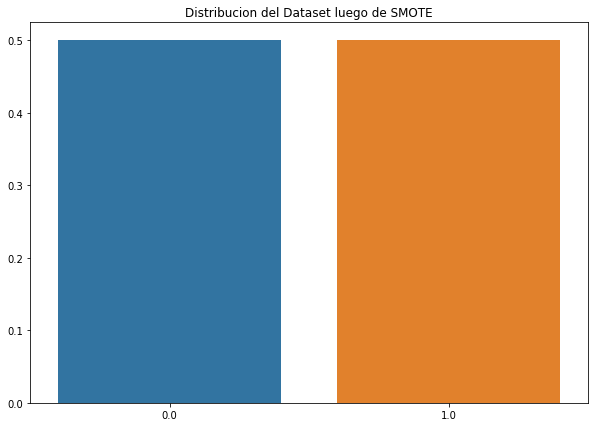

<Figure size 720x504 with 0 Axes>

In [31]:
#Metodologia SMOTE
SM = SMOTE(sampling_strategy = 1.0, random_state = random.randrange(200,1000), k_neighbors = 5, n_jobs = 2)

SMDT = NormalizedData.copy()
InputDT, TargetDT = SM.fit_resample(SMDT.drop(["not.fully.paid"], axis = 1), SMDT["not.fully.paid"])
TargetDT = TargetDT.to_frame()
print("Oversampled Input Dataframe: ")
print(InputDT.head())
print("Oversampled Target Dataframe: ")
print(TargetDT.head())

sns.barplot(x = (TargetDT["not.fully.paid"].unique()), 
            y = TargetDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/TargetDT.shape[0])
plt.title("Distribucion del Dataset luego de SMOTE")
plt.figure(2)
plt.show()

Epoch: 15; Error: 478.364132934176;
Epoch: 30; Error: 465.88469869199383;
Epoch: 45; Error: 459.5914935776692;
The maximum number of train epochs is reached


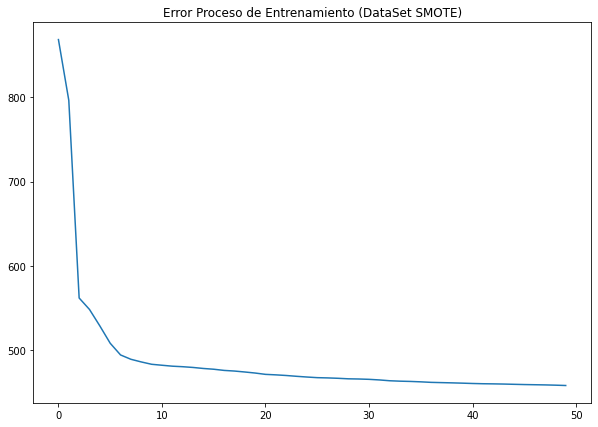

<Figure size 720x504 with 0 Axes>

In [32]:
#Red Neuronal
    
#Entradas de entrenamiento
TrainInputs = [[0 for size in range(len(InputDT.columns))] for size in range(SMDT.shape[0])]
for DtIndex in range(len(TrainInputs)):
    i = 0
    for Column in InputDT.columns:
        (TrainInputs[DtIndex])[i] = InputDT[Column][DtIndex]
        i = i + 1

#Salidas de entrenamiento
TrainTarget = [[0] for size in range(SMDT.shape[0])]
for DtIndex in range(len(TrainTarget)):
    TrainTarget[DtIndex][0] = TargetDT["not.fully.paid"][DtIndex]

#Neuronas de entrada
NInput = [[0,1] for size in range(len(InputDT.columns))]
#Estructura Red Neuronal
Network = nl.net.newff(NInput,[10,1])
NetworkError = Network.train(TrainInputs,TrainTarget, epochs = 50, goal = 0.5, show = 15)
Network.save(r"OutPut\ANN\SMOTE\Network_Dataset_SMOTE")


plt.plot(NetworkError)
plt.title("Error Proceso de Entrenamiento (DataSet SMOTE)")
plt.figure(5)
plt.show()

C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K = 1, Accuracy: 0.8601242236024844


C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Last Accuracy: 0.8601242236024844
K = 2, Accuracy: 0.8747826086956522


C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Last Accuracy: 0.8747826086956522
K = 3, Accuracy: 0.8151552795031056


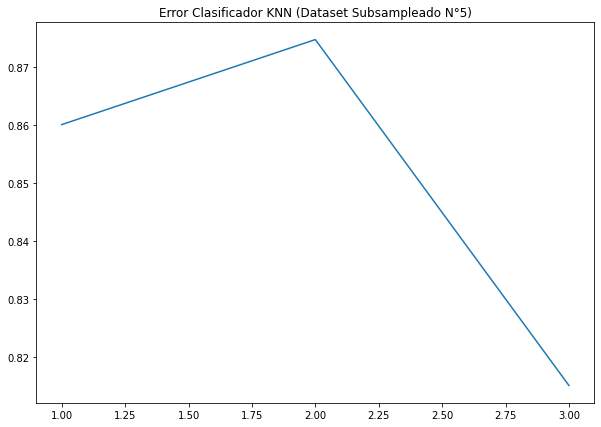

<Figure size 720x504 with 0 Axes>

In [34]:
#Clasificador KNN

XTrain, XTest, YTrain, YTest = train_test_split(InputDT, TargetDT, test_size = 0.3)

K = 1
LastAccuracy = 0

KNNmodel = KNeighborsClassifier(n_neighbors=K)
KNNmodel.fit(XTrain, YTrain)
YPredict = KNNmodel.predict(XTest)
Accuracy = metrics.accuracy_score(YTest, YPredict)
print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

AccuracyPlot = np.array(Accuracy)
KPlot = np.array(K)

while (Accuracy > LastAccuracy*0.95) and (round(Accuracy,5) != round(LastAccuracy,5)):
    K = K + 1
    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    LastAccuracy = Accuracy
    Accuracy = metrics.accuracy_score(YTest, YPredict)
    print("Last Accuracy: " + str(LastAccuracy))
    print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

    AccuracyPlot = np.append(AccuracyPlot, Accuracy)
    KPlot = np.append(KPlot, K)

pickle.dump(KNNmodel, open(r"OutPut\KNN\SMOTE\KNN_SMOTE", "wb"))
plt.plot(KPlot, AccuracyPlot)
plt.title("Error Clasificador KNN (Dataset Subsampleado N°"+str(z)+")")
plt.figure(4)
plt.show()